In [1]:
import sys; sys.path.append('../../wwa/'); from wwa import *

# broader region for plotting
Xn,Xx,Yn,Yx = [-18,52,0,35]

# region for West Africa time series analysis
xn, xx, yn, yx = [-16,20,10,17]
box_str = "_".join([str(i) for i in [xn, xx, yn, yx]])

# shapefile
sf = gpd.read_file("sf_malibf")

mapproj = cartopy.crs.PlateCarree()

bamako = get_latlon("Bamako, Mali")

fpath = "../../00_WWA_project_folder/ephemeral/00_Sahel-heat/"

# CMIP6 on JASMIN

In [ ]:
import xarray as xr
import numpy as np
import glob
import re
import geopandas as gpd
import regionmask
import os

os.chdir("/home/users/clairb/00_notebooks/24-04_sahel-heat")

import dask; dask.config.set(**{'array.slicing.split_large_chunks': True})

# broader region for plotting
Xn,Xx,Yn,Yx = [-18,52,0,35]

# region for West Africa time series analysis
xn, xx, yn, yx = [-10,20,10,17]
box_str = "_".join([str(i) for i in [xn, xx, yn, yx]])

# shapefile


In [ ]:
def wrap_lon(ds):
    
    # method to wrap longitude from (0,360) to (-180,180)
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

## Identify models with both historical & SSP data

In [2]:
varnm = "tasmin"

# list all models with available historical data
fl_hist = glob.glob('/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/day/'+varnm)
mdl_hist = [re.sub("_historical", "", "_".join(fnm.split("/")[6:10])) for fnm in fl_hist]

# list all models with available SSP585 data
fl_ssp = glob.glob('/badc/cmip6/data/CMIP6/ScenarioMIP/*/*/ssp585/*/day/'+varnm)
mdl_ssp = [re.sub("_ssp585", "", "_".join(fnm.split("/")[6:10])) for fnm in fl_ssp]

# list all model variants for which both historical & SSP are available
model_vars = sorted([m for m in mdl_hist if m in mdl_ssp])

# identify unique models & get first ensemble member for each
models = list(set(["_".join(m.split("_")[:2]) for m in model_vars]))
models = [[v for v in model_vars if m in v][0] for m in models]

In [ ]:
# filter out any models already processed on HPC
synda_models = ['ACCESS-CM2',
                 'ACCESS-ESM1-5',
                 'AWI-CM-1-1-MR',
                 'CanESM5',
                 'E3SM-1-0',
                 'EC-Earth3',
                 'EC-Earth3-Veg',
                 'EC-Earth3-Veg-LR',
                 'INM-CM4-8',
                 'INM-CM5-0',
                 'MIROC6',
                 'MPI-ESM1-2-HR',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM2-LM',
                 'NorESM2-MM']
models = [m for m in models if not m.split("_")[1] in synda_models]

In [ ]:
# cut out time series & spatial pattern for individual files
for mdl in models:

    print(mdl, end = "")
    inst, gcm, em = mdl.split("_")

    sp_fnm = "spatial/"+varnm+"_"+mdl+"_"+box_str+"_spatial-monthly.nc"
    box_fnm = "daily/"+varnm+"_"+mdl+"_"+box_str+"_daily.nc"
    sf_fnm = "daily/"+varnm+"_"+mdl+"_"+sf_str+"_daily.nc"

    # if os.path.exists(sp_fnm) and os.path.exists(box_fnm) and os.path.exists(sf_fnm): 
    if os.path.exists(sf_fnm): 
        print("Already processed")
        continue

    # list all relevant files (not including anything past 2050 at the moment)
    fl_h = glob.glob("/badc/cmip6/data/CMIP6/CMIP/"+inst+"/"+gcm+"/historical/"+em+"/day/"+varnm+"/*/latest/*.nc")
    fl_s = glob.glob("/badc/cmip6/data/CMIP6/ScenarioMIP/"+inst+"/"+gcm+"/ssp585/"+em+"/day/"+varnm+"/*/latest/*.nc")
    fl_s = [fnm for fnm in fl_s if int(fnm[-20:-16]) <= 2050]

    fl = fl_h + fl_s
    if(len(fl) == 0): continue

    for fnm in fl:
        
        # load the data
    
        # can't convert units or calendar on Jasmin so will have to handle that later

        # # monthly spatial pattern
        # sp = da.groupby("time.month").mean()
        # sp.to_netcdf("cmip6/"+re.sub("day", "spatial", fnm.split("/")[-1]))

        # # get daily time series over rectangular region
        # ts_box = da.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])
        # ts_box.to_netcdf("cmip6/"+re.sub("day", "daily-box", fnm.split("/")[-1]))

        # get daily time series over shapefile region
        rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).sum("region")
        ts_sf = da.where(rm == 1).mean(["lat", "lon"])
        ts_sf.to_netcdf("cmip6/"+re.sub("day", "daily-sf", fnm.split("/")[-1]))

        print(".", end = "")
    print("")

# CMIP6 on HPC

## Extract subset of model data using cdo

In [3]:
jasmin_models = ['AS-RCEC_TaiESM1_r1i1p1f1',
                 'AWI_AWI-CM-1-1-MR_r1i1p1f1',
                 'BCC_BCC-CSM2-MR_r1i1p1f1',
                 'CAMS_CAMS-CSM1-0_r2i1p1f1',
                 'CAS_FGOALS-g3_r1i1p1f1',
                 'CCCma_CanESM5_r10i1p1f1',
                 'CMCC_CMCC-CM2-SR5_r1i1p1f1',
                 'CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2',
                 'CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2',
                 'CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2',
                 'CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1',
                 'CSIRO_ACCESS-ESM1-5_r1i1p1f1',
                 'EC-Earth-Consortium_EC-Earth3-CC_r1i1p1f1',
                 'EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1',
                 'EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1',
                 'INM_INM-CM4-8_r1i1p1f1',
                 'INM_INM-CM5-0_r1i1p1f1',
                 'IPSL_IPSL-CM6A-LR_r1i1p1f1',
                 'KIOST_KIOST-ESM_r1i1p1f1',
                 'MIROC_MIROC-ES2L_r1i1p1f2',
                 'MIROC_MIROC6_r10i1p1f1',
                 'MOHC_UKESM1-0-LL_r1i1p1f2',
                 'MPI-M_MPI-ESM1-2-LR_r1i1p1f1',
                 'MRI_MRI-ESM2-0_r1i1p1f1',
                 'NCC_NorESM2-LM_r1i1p1f1',
                 'NCC_NorESM2-MM_r1i1p1f1',
                 'NIMS-KMA_KACE-1-0-G_r1i1p1f1',
                 'NIMS-KMA_UKESM1-0-LL_r14i1p1f2',
                 'NUIST_NESM3_r1i1p1f1']

jasmin_models = sorted([m.split("_")[1] for m in jasmin_models])

In [4]:
varnm = "tasmin"

# identify models with full range of required data
synda_path = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/"
all_models = sorted([m.split("/")[-1] for m in glob.glob(synda_path+"*")])
models = []
for m in all_models:
    
    fl = sorted(glob.glob(synda_path+m+"/"+varnm+"/*"))
    fl = [fnm for fnm in fl if "day" in fnm]  # filter out legacy monthly data
    
    if len(fl) == 0: continue
    if int(fl[0][-20:-16]) <= 1950 and int(fl[-1][-20:-16]) >= 2050: models.append(m)

In [ ]:
# extract subset of daily data
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat/cmip6/raw/"
for mdl in models:
    fl = sorted(glob.glob(synda_path+mdl+"/"+varnm+"/*.nc"))
    fl = [fnm for fnm in fl if int(fnm[-20:-16]) <= 2050]
    
    for fnm in fl:
        new_fnm = re.sub("_day", "_africa-mam_day", outpath+fnm.split("/")[-1])
        if not os.path.exists(new_fnm):
            ! module load cdo; cdo -s -f nc -selseason,MAM -sellonlatbox,$Xn,$Xx,$Yn,$Yx $fnm $new_fnm
            clear_output(wait = False)

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'


## Compile individual models

In [48]:
varnm = "tasmax"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat/cmip6/raw/"

In [58]:
models = list(set([re.sub("historical", "ssp585", "_".join(fnm.split("_")[7:-1])) for fnm in glob.glob(outpath+varnm+"*.nc")]))
for mdl in models:
    
    fl = sorted(glob.glob(outpath+varnm+"*"+re.sub("ssp585", "*", mdl)+"*.nc"))
    
    new_fnm = re.sub("historical_","",re.sub("raw/","",fl[0][:-11])+fl[-1][-11:])
    
    # load all the data
    da = convert_units_to(wrap_lon(xr.open_mfdataset(fl))[varnm].reset_coords(drop = True), "degC")
    
    # monthly spatial pattern
    sp_fnm = re.sub("africa-mam_day", "spatial", new_fnm)[:-20]+"1980-2024.nc"
    if not os.path.exists(sp_fnm):
        sp = da.sel(time = slice("1980", "2024")).groupby("time.month").mean()
        sp.to_netcdf(sp_fnm)
    
    # get daily time series over rectangular region
    box_fnm = re.sub("africa-mam_day", "ts"+re.sub("_","-",box_str), new_fnm)
    if not os.path.exists(box_fnm):
        rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sum("region")
        ts_box = da.sel(lon = slice(xn,xx), lat = slice(yn,yx)).where(rm == 1).mean(["lat", "lon"])
        ts_box.to_netcdf(box_fnm)
    
    # get daily time series over shapefile region
    sf_fnm = re.sub("africa-mam_day", "ts-sf", new_fnm)
    if not os.path.exists(sf_fnm):
        rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).sum("region")
        ts_sf = da.where(rm == 1).mean(["lat", "lon"])
        ts_sf.to_netcdf(sf_fnm)

## Time series for climate explorer

In [61]:
varnm = "tasmin"
ndays = 5

In [39]:
for fnm in glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat/cmip6/"+varnm+"*ts-sf*"):
    
    mdl = "_".join(fnm.split("_")[6:8])
    
    ts = xr.open_dataset(fnm)[varnm].rolling(time = ndays).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
    
    csv_fnm = "sahel-heat_cmip6_"+varnm[0]+varnm[-1]+str(ndays)+"x-april_mali-bf_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" April maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
    str2 = "# "+varnm+" [degC] April maximum of "+str(ndays)+"-day "+varnm[-3:]+"imum temperatures in southern Mali & Burkina Faso at "+csv_fnm+".dat"
    head = "# year "+varnm
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

In [62]:
for fnm in glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat/cmip6/"+varnm+"_ts"+re.sub("_","-",box_str)+"*"):
    
    mdl = "_".join(fnm.split("_")[6:8])
    
    ts = xr.open_dataset(fnm)[varnm].rolling(time = ndays).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
    
    csv_fnm = "sahel-heat_cmip6_"+varnm[0]+varnm[-1]+str(ndays)+"x-april_"+box_str+"_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" April maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
    str2 = "# "+varnm+" [degC] April maximum of "+str(ndays)+"-day "+varnm[-3:]+"imum temperatures in Sahel region at "+csv_fnm+".dat"
    head = "# year "+varnm
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

# Check spatial patterns


## Observed spatial patterns

In [67]:
# MSWX
for varnm in ["tmax","tmin"]:

    fl = sorted(glob.glob(fpath+"mswx/"+varnm+"_*.nc"))
    da = xr.open_mfdataset(fl)[varnm].groupby("time.month").mean()
    da.to_netcdf("data/spatial_"+varnm+"_mswx.nc")

In [2]:
# ERA5
for varnm in ["tmax", "tmin"]:
    
    da = wrap_lon(xr.open_dataset(fpath+"era5_"+varnm+"_daily_af_extended_-18-52E_0-35N_su.nc"))[varnm].sel(time = slice("1989", "2024")).groupby("time.month").mean()
    da.to_netcdf("data/spatial_"+varnm+"_era5.nc")

In [2]:
# CPC
for varnm in ["tmax", "tmin"]:
    
    da = wrap_lon(xr.open_mfdataset("../../00_WWA_project_folder/live/data/cpc/"+varnm+"*.nc"))[varnm].groupby("time.month").mean().sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))
    da.to_netcdf("data/spatial_"+varnm+"_cpc.nc")

## Plots of spatial patterns

In [83]:
varnm = "tmax"
datasets = ["cpc", "era5", "mswx"]
obs = {ds : xr.open_dataset("data/spatial_"+varnm+"_"+ds+".nc")[varnm].sel(month = 4) for ds in datasets}

vrange = {"tmax" : {"vmin" : 10, "vmax" : 40}, "tmin" : {"vmin" : 5, "vmax" : 30}}[varnm]

In [ ]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,4), dpi = 100, subplot_kw = {"projection" : mapproj})

for i in range(3):
    ax = axs[i]
    ds = list(obs.keys())[i]
    da = obs[ds]
    cbar = da.plot(ax = ax, **vrange, cmap = "YlOrRd", add_colorbar = False)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "k", lw = 1.5)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.07, pad = 0.07, label = "Temperature (°C)", extend = "both")
plt.suptitle("Spatial pattern of April "+varnm+" in observational datasets", y = 0.7, fontweight = "bold")

plt.savefig("fig/spatial-pattern_t"+varnm[-1]+"5x_obs.png")

In [68]:
varnm = "tasmax" 
fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat/cmip6/"+varnm+"_spatial*"))

In [69]:
sp = {}
for fnm in fl:
    mdl = fnm.split("_")[6]
    da = xr.open_dataset(fnm)[varnm]
    rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sum("region")
    da = da.where(rm == 1)
    sp[mdl] = da

In [ ]:
fig, axs = plt.subplots(ncols = 5, nrows = 4, figsize = (20,14), dpi = 100, subplot_kw = {"projection" : mapproj})

for i in range(len(fl)):
    ax = fig.axes[i]
    ds = list(sp.keys())[i]
    
    da = sp[ds].sel(month = 4)
    da.plot(ax = ax, cmap = "YlOrRd", cbar_kwargs = {"location" : "bottom", "label" : "Temperature (°C)", "pad" : 0.07})
    ax.set_title(ds)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "k", lw = 1.5)
    
for i in range(len(fl), 20): fig.axes[i].set_axis_off()
    
plt.suptitle("Spatial pattern of April t"+varnm[-3:]+" in CMIP6 climate models", y = 0.9, fontweight = "bold")
    
plt.savefig("fig/spatial-pattern_t"+varnm[-1]+"5x_cmip6.png")

# Check seasonal cycle


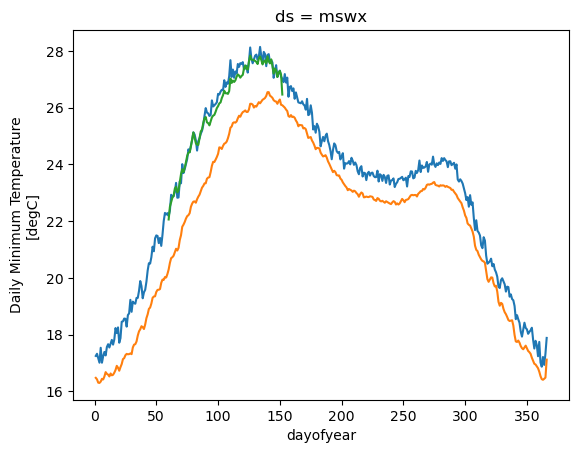

In [58]:
varnm = "tasmin"
obs_sc = xr.concat([xr.open_dataset(fnm).groupby("time.dayofyear").mean()["t"+varnm[-3:]].expand_dims(ds = [fnm.split("_")[1]]) for fnm in sorted(glob.glob("data/t"+varnm[-3:]+"_*_mali*.nc"))], "ds")

for i in range(3):
    obs_sc.isel(ds = i).plot()
# all obs have similar seasonal cycle

In [ ]:
obs_sc = xr.open_dataset("data/t"+varnm[-3:]+"_mswx_mali-burkinafaso.nc")["t"+varnm[-3:]].groupby("time.dayofyear").mean()

fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat/cmip6/"+varnm+"_ts-16*"))
cmip6_sc = xr.concat([xr.open_dataset(fnm).sel(time = slice("1979", "2024")).groupby("time.dayofyear").mean()[varnm].expand_dims(ds = [fnm.split("_")[-4]]) for fnm in fl], "ds")

fig, axs = plt.subplots(ncols = 5, nrows = 4, figsize = (20,10), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    ax = fig.axes[i]
    da = cmip6_sc.isel(ds = i)
    
    ax.plot(da.dayofyear, da)
    ax.plot(obs_sc.dayofyear, obs_sc, color = "k")
    ax.set_title(da.ds.values)
    [ax.axvline(x, color = "darkred", alpha = 0.2) for x in [91,121]]
    
for i in range(len(fl), 20): fig.axes[i].set_axis_off()
    
plt.suptitle("MAM seasonal cycle of t"+varnm[-3:]+" over Sahel region in CMIP6 climate models (blue) & MSWX", y = 0.97, fontweight = "bold")
    
plt.savefig("fig/seasonal-cycle_t"+varnm[-1]+"5x_cmip6.png")